# AutoEncoder to Denoise the images
Denoising autoencoder is just the extension of simple autoencoders.
Vincent et al 2008 ICML Paper, extracting and composing robust features with denoising autoencoders - the author found that they can imporve the robustness of the internal layers - latent space representation - by purposely inducing the noise to their signal

They were invented to help
1. Hidden layer to learn more robust features
2. Reduce risk of overfitting in autoencoder
3. Prevent autoencoder to learn a simple identity function (that would make it just repeat what is entered into the input)

## Features of AutoEncoder
1. Denoise the image using DeepLearning
2. Anomaly Detection with Keras, Tensorflow, Deep Learning
3. Compressing the image to a latent space


## What is noise ?
1. Produced by faulty or poor quality image sensor
2. Random Variation in brightness or color
3. Quantization Noise
4. Artifact due to JPEG Compression
5. Image perturbation produced by image scanner or threshold processing
6. Poor paper quality


In [1]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import Flatten, Dense, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

In [2]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32,64), latentDim=16):
        inputShape = (height, width, depth)
        chanDim = -2
        
        inputs = Input(shape=inputShape)
        x = inputs
        
        for f in filters:
            x = Conv2D(f, (3,3), strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)
        
        encoder = Model(inputs, latent, name='encoder')
        
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        
        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3,3), strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
        x = Conv2DTranspose(depth, (3,3), padding='same')(x)
        outputs = Activation('sigmoid')(x)
        
        decoder = Model(latentInputs, outputs, name='decoder')
        
        autoencoder = Model(inputs, decoder(encoder(inputs)),
                           name='autoencoder')
        return (encoder, decoder, autoencoder)

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
EPOCHS = 3
BS = 32

(trainX,_),(testX,_) = mnist.load_data()

In [5]:
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype('float32')/255.
testX = testX.astype('float32')/255.

In [6]:
# adding noise to the image

trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)

trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

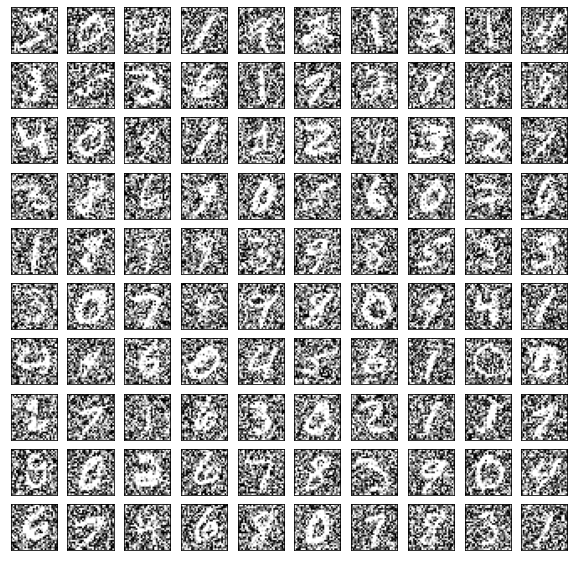

In [7]:
plt.figure(figsize=(10, 10))

for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    img = trainXNoisy[i].reshape(28,28)
    plt.imshow(img, cmap='gray')

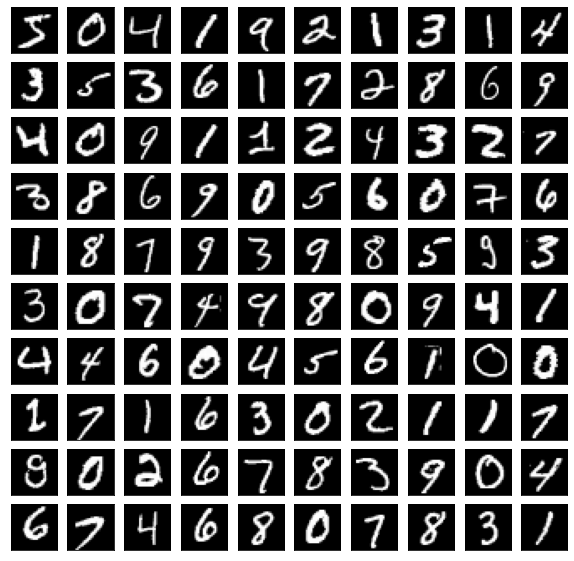

In [8]:
plt.figure(figsize=(10, 10))

for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    img = trainX[i].reshape(28,28)
    plt.imshow(img, cmap='gray')

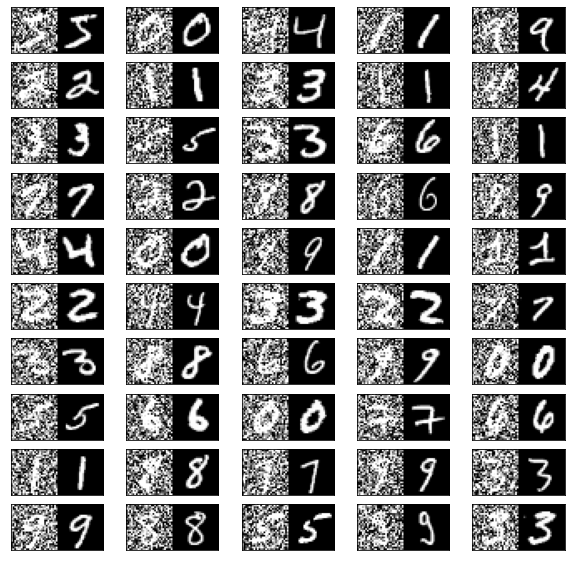

In [9]:
plt.figure(figsize=(10, 10))

for i in range(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img1 = trainXNoisy[i].reshape(28,28)
    img2 = trainX[i].reshape(28,28)
    img = np.hstack((img1, img2))
    plt.imshow(img, cmap='gray')

In [12]:
# building the model
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)


In [ ]:
opt = Adam(lr=1e-3)
autoencoder.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
# categorical_crossentropy
# binary_crossentropy
# mse

In [14]:
H = autoencoder.fit(
    trainXNoisy, trainX,
    validation_data=(testXNoisy, testX),
    epochs=EPOCHS,
    batch_size=BS
    )

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 18s 296us/sample - loss: 0.0172 - accuracy: 0.8111 - val_loss: 0.0170 - val_accuracy: 0.8094
Epoch 2/3
60000/60000 [==============================] - 20s 342us/sample - loss: 0.0168 - accuracy: 0.8113 - val_loss: 0.0166 - val_accuracy: 0.8101
Epoch 3/3
60000/60000 [==============================] - 19s 312us/sample - loss: 0.0165 - accuracy: 0.8114 - val_loss: 0.0165 - val_accuracy: 0.8110


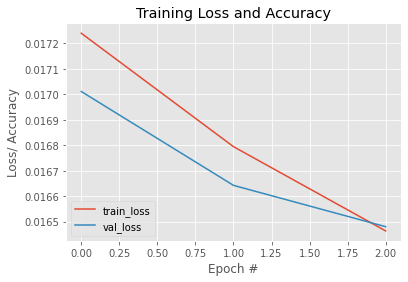

In [15]:
N = np.arange(0, EPOCHS)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/ Accuracy')
plt.legend(loc='lower left')
plt.savefig('train_logs.jpg')

# Visualizing the Results

In [ ]:
decoded = autoencoder.predict(testXNoisy)

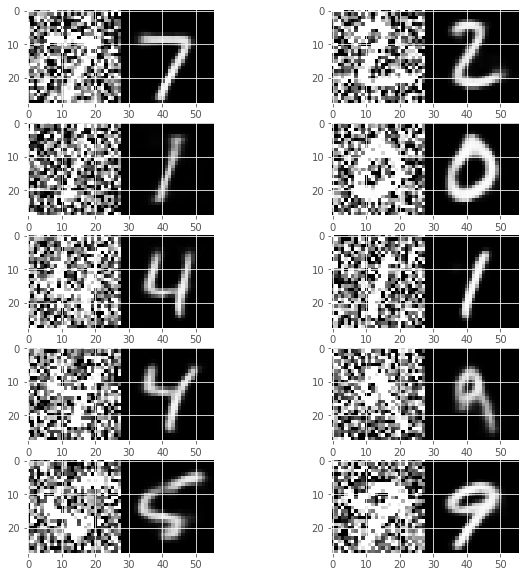

In [20]:
outputs = None

plt.figure(figsize=(10,10))

for i in range(0, 10):
    original = (testXNoisy[i]*255).astype('uint8')
    recon = (decoded[i]*255).astype('uint8')
    
    output = np.hstack([original, recon])
    plt.subplot(5,2,i+1)
    plt.imshow(output, cmap='gray')
    if outputs is None:
        outputs = output
    else:
        outputs = np.vstack([outputs, output])

# cv2.imwrite('final_recon.jpg', outputs)

## Conclusion

We can clearly see that denoising autoencoder was able to recover the original signal from the images while removing the noise

AutoEncoder can be used to automatically pre-process the images to facilitate better ocr accuracy.

In the case of face recognition - this autoencoder can work with normal images with noise and generate the faces without noise - that enhances the accuracy of face recognition algorithm.